In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/60k-stack-overflow-questions-with-quality-rate/valid.csv
/kaggle/input/60k-stack-overflow-questions-with-quality-rate/train.csv


In [2]:
!pip install Datasets

In [3]:
import pandas as pd
import re
import torch
import os
from bs4 import BeautifulSoup
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader
import datasets
from datasets import Dataset, DatasetDict
from tqdm import tqdm
#import evaluate

In [4]:
# Load XLNet tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('xlnet-base-cased', num_labels=3)
model = AutoModelForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=3)

# Load data
df_train = pd.read_csv('/kaggle/input/60k-stack-overflow-questions-with-quality-rate/train.csv')
df_valid = pd.read_csv('/kaggle/input/60k-stack-overflow-questions-with-quality-rate/valid.csv')

# Display columns and first few rows of df_train
print(df_train.columns)
print(df_train.head())

# Preprocess data
df_train = df_train.filter(['Title', 'Body', 'Tags', 'Y'])
df_train['Y'] = df_train['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})

df_valid = df_valid.filter(['Title', 'Body', 'Tags', 'Y'])
df_valid['Y'] = df_valid['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Index(['Id', 'Title', 'Body', 'Tags', 'CreationDate', 'Y'], dtype='object')
         Id                                              Title  \
0  34552656             Java: Repeat Task Every Random Seconds   
1  34553034                  Why are Java Optionals immutable?   
2  34553174  Text Overlay Image with Darkened Opacity React...   
3  34553318         Why ternary operator in swift is so picky?   
4  34553755                 hide/show fab with scale animation   

                                                Body  \
0  <p>I'm already familiar with repeating tasks e...   
1  <p>I'd like to understand why Java 8 Optionals...   
2  <p>I am attempting to overlay a title over an ...   
3  <p>The question is very simple, but I just cou...   
4  <p>I'm using custom floatingactionmenu. I need...   

                                                Tags         CreationDate  \
0                                     <java><repeat>  2016-01-01 00:21:59   
1                                   

In [5]:
class Preprocessing:
    def __get_body_tag_text(self, text):
        soup = BeautifulSoup(text, features='xml')
        return soup.get_text()

    def __lower_and_punc_removal(self, text):
        text = text.lower()
        text = re.sub(r'[^(a-zA-Z)\s]', '', text)
        return text

    def __init__(self, df):
        self.df = df
        self.df['Body_Between_Tags'] = self.df['Body'].apply(self.__get_body_tag_text)
        self.df['Final_clean'] = self.df['Body_Between_Tags'].apply(self.__lower_and_punc_removal)

PreprocessedObject_train = Preprocessing(df=df_train)
PreprocessedObject_valid = Preprocessing(df=df_valid)

PreprocessedObject_train.df.dropna(inplace=True)
PreprocessedObject_valid.df.dropna(inplace=True)
PreprocessedObject_train.df.reset_index(inplace=True)
PreprocessedObject_valid.df.reset_index(inplace=True)

df_train_final = PreprocessedObject_train.df
df_valid_final = PreprocessedObject_valid.df

df_train_final.drop(['index', 'Tags', 'Body', 'Title'], inplace=True, axis=1)
df_valid_final.drop(['index', 'Tags', 'Body', 'Title'], inplace=True, axis=1)

# Retain the label column
df_train_final = df_train_final[['Final_clean', 'Y']]
df_valid_final = df_valid_final[['Final_clean', 'Y']]


/tmp/ipykernel_34/705171541.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, features='xml')
/tmp/ipykernel_34/705171541.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, features='xml')


In [6]:
# Create DatasetDict
datasets_train_test = DatasetDict({
    "train": Dataset.from_pandas(df_train_final),
    "test": Dataset.from_pandas(df_valid_final)
})

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["Final_clean"], padding="max_length", truncation=True)

tokenized_datasets = datasets_train_test.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Final_clean'])
tokenized_datasets = tokenized_datasets.rename_column("Y", "labels")
tokenized_datasets.set_format("torch")

# Create dataloaders
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=8)
eval_dataloader = DataLoader(tokenized_datasets["test"], batch_size=8)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

Map:   0%|          | 0/45000 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [7]:
def collate_fn(batch):
    # Get input_ids and attention_mask tensors
    input_ids = [torch.tensor(example["input_ids"]) for example in batch]
    attention_mask = [torch.tensor(example["attention_mask"]) for example in batch]

    # Pad each sequence to the maximum length
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)  # Assuming you have attention masks

    # Check if "labels" key exists in examples
    if "labels" in batch[0] and batch[0]["labels"] is not None:
        labels = torch.tensor([example["labels"] for example in batch])
    else:
        labels = None  # Set labels to None if not present

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }


In [8]:
# Adjust batch size and sequence length
batch_size = 4  # Reduce batch size
max_seq_length = 128  # Limit sequence length

# Tokenize datasets with adjusted parameters
def tokenize_function(examples):
    # Tokenize the text
    tokenized_inputs = tokenizer(examples["Final_clean"], padding="max_length", truncation=True, max_length=max_seq_length)

    # Include labels in the tokenized dataset
    tokenized_inputs["labels"] = examples["Y"]

    return tokenized_inputs


tokenized_datasets = datasets_train_test.map(tokenize_function, batched=True)

# Create dataloaders with adjusted batch size
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
eval_dataloader = DataLoader(tokenized_datasets["test"], batch_size=batch_size, collate_fn=collate_fn)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

Map:   0%|          | 0/45000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [9]:
print(df_train_final.head())
print(df_valid_final.head())


                                         Final_clean  Y
0  im already familiar with repeating tasks every...  0
1  id like to understand why java  optionals were...  2
2  i am attempting to overlay a title over an ima...  2
3  the question is very simple but i just could n...  2
4  im using custom floatingactionmenu i need to i...  2
                                         Final_clean  Y
0                                                     1
1                                                     1
2  im trying to extract us states from wiki url a...  2
3                                                     1
4                                                     1


In [10]:
print(tokenized_datasets)
print(tokenized_datasets['test'])  # Use the correct key 'test' to access the test dataset


DatasetDict({
    train: Dataset({
        features: ['Final_clean', 'Y', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 45000
    })
    test: Dataset({
        features: ['Final_clean', 'Y', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 15000
    })
})
Dataset({
    features: ['Final_clean', 'Y', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 15000
})


In [11]:
from torch.nn.utils.rnn import pad_sequence


In [12]:
import torch
from tqdm import tqdm

# Move model to appropriate device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Number of epochs and training steps
num_epochs = 3  # Adjust this as needed
num_training_steps = num_epochs * len(train_dataloader)

# Create a single progress bar for the entire training process
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        if batch is not None and isinstance(batch, dict) and all(v is not None for v in batch.values()):  # Check if batch is not None and contains valid data
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            progress_bar.update(1)
        else:
            print("Warning: Empty or invalid batch encountered.")

progress_bar.close()  # Close the progress bar after the training loop completes


100%|██████████| 33750/33750 [45:46<00:00, 12.29it/s]


In [13]:
correct = 0
total = 0
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    correct += torch.sum(predictions == batch["labels"]).item()
    total += len(predictions)

accuracy = correct / total
print("Accuracy:", accuracy)


Accuracy: 0.8520666666666666


In [14]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


2024-06-30 09:17:14.478613: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 09:17:14.478727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 09:17:14.618020: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


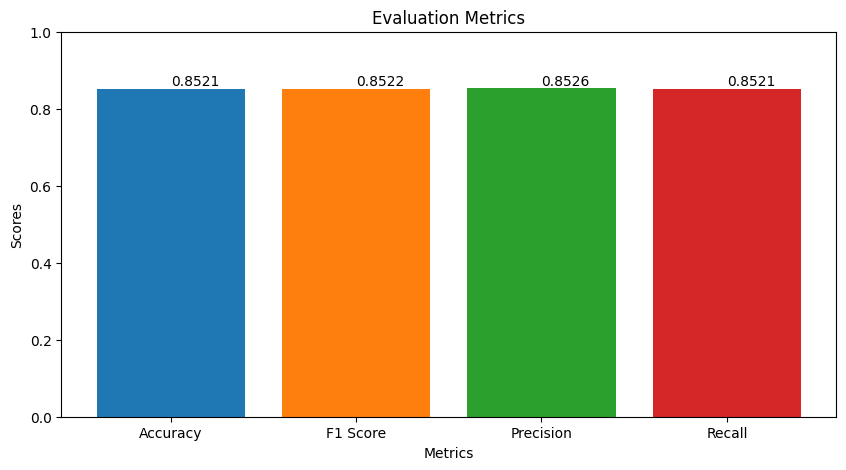

In [15]:
import evaluate
import matplotlib.pyplot as plt

# Initialize the metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

model.eval()

# Evaluate the model on the evaluation dataset
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    # Add batch results to the metrics
    accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])
    f1_metric.add_batch(predictions=predictions, references=batch["labels"])
    precision_metric.add_batch(predictions=predictions, references=batch["labels"])
    recall_metric.add_batch(predictions=predictions, references=batch["labels"])

# Compute the metrics
accuracy = accuracy_metric.compute()['accuracy']
f1 = f1_metric.compute(average='weighted')['f1']
precision = precision_metric.compute(average='weighted')['precision']
recall = recall_metric.compute(average='weighted')['recall']

# Store the metrics in a dictionary for easy plotting
metrics = {
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall
}

# Colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # You can customize these colors

# Plot the metrics as a bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)  # Assuming metrics are between 0 and 1

# Add values on top of the bars for better visualization
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom')  # va: vertical alignment

plt.show()


In [18]:
import pandas as pd
from IPython.display import FileLink



# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Score': [accuracy, f1, precision, recall]
})

# Save to CSV file
metrics_df.to_csv('metrics_xlnet.csv', index=False)

# Create a download link for the CSV file
FileLink(r'metrics_xlnet.csv')


/kaggle/working/metrics_xlnet.csv

In [19]:
import json

# Assuming `metrics` is a dictionary containing your metrics
metrics = {
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall
}

# Save the metrics to a JSON file in Kaggle environment
metrics_filename = 'metrics_xlnet.json'
with open(metrics_filename, 'w') as f:
    json.dump(metrics, f)

# Download the JSON file to your local machine
from IPython.display import FileLink
FileLink(r'metrics_xlnet.json')


/kaggle/working/metrics_xlnet.json

In [20]:
import torch

# Assuming `model` is your trained model
# Save the model's state dictionary to a file in Kaggle environment
model_path = 'trained_model_xlnet.pth'
torch.save(model.state_dict(), model_path)

# Download the model file to your local machine
from IPython.display import FileLink
FileLink(r'trained_model_xlnet.pth')



/kaggle/working/trained_model_xlnet.pth

In [21]:
!pip install gradio

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 86.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 101.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 8.7 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=5584 sha256=0307128c8c385a362aae79e72c0b426f34904567b460390565c3fb73e8fd9b49
  Stored in directory: /root/.cache/pip/wheels/bd/65/9a/671fc6dcde07d4418df0c592f8df512b26d7a0029c2a23dd81
Successfully built ffmpy
  Attempting uninstall: websockets
    Found existing installation: websockets 12.0
    Uninstalling websockets-12.0:
      Successfully uninstalled websockets-12.0
  Attempting unins

In [22]:
import torch
from transformers import XLNetForSequenceClassification, XLNetTokenizer
import gradio as gr

# Load the model and tokenizer for XLNet
model_path = '/kaggle/working/trained_model_xlnet.pth'
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=3)  # Adjust num_labels based on your task
model.load_state_dict(torch.load(model_path))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

# Mapping from numerical predictions to original labels
label_map = {0: 'LQ_CLOSE', 1: 'LQ_EDIT', 2: 'HQ'}

def classify_text(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()
    return label_map[predicted_class]

# Create Gradio interface
iface = gr.Interface(
    fn=classify_text,
    inputs=gr.Textbox(lines=2, label="Enter text to classify"),
    outputs=gr.Label(num_top_classes=3),
    title="XLNet Text Classification",
    description="Enter text and classify its category using a fine-tuned XLNet model."
)

# Launch the interface
iface.launch()


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on public URL: https://b6c1c4e14c11a406ac.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
